In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import warnings
import pandas as pd

In [51]:
# df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
# df.drop(columns=['Adj Close'], inplace=True)

# df['Date'] = pd.to_datetime(df['Date'])
# mask = (df['Date'] >= '2023-03-01') & (df['Date'] <=  '2023-10-31')
# df = df[mask]
# df.head(5)
df1 = pd.read_csv('BTC-USD.csv', index_col='Date', parse_dates=True)
df1.drop(columns=['Adj Close'], inplace=True)

# Não é necessário converter 'Date' para datetime quando já é o índice
mask = (df1.index >= '2023-03-01') & (df1.index <= '2023-10-31')
df = df1[mask]

print(df.head(5))
print(df.tail(5))


                    Open          High           Low         Close  \
Date                                                                 
2023-03-12  20628.029297  22185.031250  20448.806641  22163.949219   
2023-03-13  22156.406250  24550.837891  21918.199219  24197.533203   
2023-03-14  24201.765625  26514.716797  24081.183594  24746.074219   
2023-03-15  24770.925781  25240.615234  23964.910156  24375.960938   
2023-03-16  24373.457031  25190.326172  24225.111328  25052.789063   

                 Volume  
Date                     
2023-03-12  29279035521  
2023-03-13  49466362688  
2023-03-14  54622230164  
2023-03-15  43655701450  
2023-03-16  33866061747  
                    Open          High           Low         Close  \
Date                                                                 
2023-10-27  34156.500000  34238.210938  33416.886719  33909.800781   
2023-10-28  33907.722656  34399.390625  33874.804688  34089.574219   
2023-10-29  34089.371094  34743.261719  33947.5

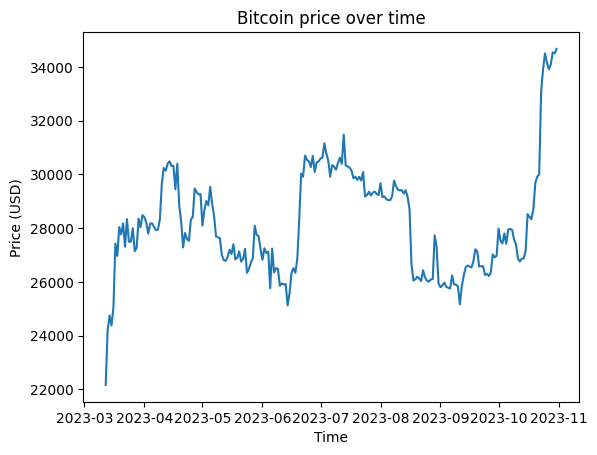

In [52]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

In [53]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((234, 4), (234,))

In [54]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [55]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(86, 100, 4) (86, 50)


In [56]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()
y_mm[0]

array([0.37485149, 0.49293201, 0.62887502, 0.61967659, 0.68231239,
       0.67057411, 0.6651011 , 0.64837576, 0.6817282 , 0.63358952,
       0.66230915, 0.6648604 , 0.67388373, 0.67633829, 0.71917875,
       0.68887944, 0.66781262, 0.6194412 , 0.6540648 , 0.65008805,
       0.64038649, 0.65983944, 0.67635281, 0.65801406, 0.74473966,
       0.65340922, 0.65034922, 0.64661646, 0.63835946, 0.61522046,
       0.61980796, 0.61005829, 0.61939371, 0.60844176, 0.63345299,
       0.5608654 , 0.56490213, 0.57510557, 0.56356645, 0.57224832,
       0.57526115, 0.5687344 , 0.56511972, 0.60075849, 0.55886945,
       0.56100645, 0.55264199, 0.55008558, 0.55006387, 0.56115828])

In [57]:
y_trans[99:149].squeeze(1)

array([0.37485149, 0.49293201, 0.62887502, 0.61967659, 0.68231239,
       0.67057411, 0.6651011 , 0.64837576, 0.6817282 , 0.63358952,
       0.66230915, 0.6648604 , 0.67388373, 0.67633829, 0.71917875,
       0.68887944, 0.66781262, 0.6194412 , 0.6540648 , 0.65008805,
       0.64038649, 0.65983944, 0.67635281, 0.65801406, 0.74473966,
       0.65340922, 0.65034922, 0.64661646, 0.63835946, 0.61522046,
       0.61980796, 0.61005829, 0.61939371, 0.60844176, 0.63345299,
       0.5608654 , 0.56490213, 0.57510557, 0.56356645, 0.57224832,
       0.57526115, 0.5687344 , 0.56511972, 0.60075849, 0.55886945,
       0.56100645, 0.55264199, 0.55008558, 0.55006387, 0.56115828])

In [58]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (0, 100, 4) (0, 50)
Testing Shape: (86, 100, 4) (86, 50)


In [59]:
# # convert to pytorch tensors
# X_train_tensors = torch.tensor(X_train)
# X_test_tensors = torch.tensor(X_test)
# y_train_tensors = torch.tensor(y_train)
# y_test_tensors = torch.tensor(y_test)

In [60]:
# # reshaping to rows, timestamps, features
# X_train_tensors_final = torch.reshape(X_train_tensors,   
#                                       (X_train_tensors.shape[0], 100, 
#                                        X_train_tensors.shape[2]))
# X_test_tensors_final = torch.reshape(X_test_tensors,  
#                                      (X_test_tensors.shape[0], 100, 
#                                       X_test_tensors.shape[2])) 
# convert to pytorch tensors
X_train_tensors_final = torch.tensor(X_train, dtype=torch.float32)
X_test_tensors_final = torch.tensor(X_test, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

# reshaping to batch_size, seq_len, input_size
X_train_tensors_final = X_train_tensors_final.view(-1, 100, 4)
X_test_tensors_final = X_test_tensors_final.view(-1, 100, 4)

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([0, 100, 4]) torch.Size([0, 50])
Testing Shape: torch.Size([86, 100, 4]) torch.Size([86, 50])


In [61]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[2.71231094e+04, 2.71299824e+04, 2.54451680e+04, 2.15132926e+10],
       [2.57321094e+04, 2.73138203e+04, 2.54348672e+04, 2.19296707e+10],
       [2.72356504e+04, 2.73321816e+04, 2.61469883e+04, 1.95300451e+10],
       [2.63476543e+04, 2.67975137e+04, 2.62466641e+04, 1.19048243e+10]])

In [62]:
X.iloc[-149:-145]

,Open,High,Low,Volume
Date,,,,
2023-06-05,27123.109375,27129.982422,25445.167969,21513292646
2023-06-06,25732.109375,27313.820313,25434.867188,21929670693
2023-06-07,27235.650391,27332.181641,26146.988281,19530045082
2023-06-08,26347.654297,26797.513672,26246.664063,11904824295


In [63]:
y_check[-1]

array([25833.34375 , 26228.324219, 26539.673828, 26608.693359,
       26568.28125 , 26534.1875  , 26754.28125 , 27211.117188,
       27132.007813, 26567.632813, 26579.568359, 26579.390625,
       26256.826172, 26298.480469, 26217.25    , 26352.716797,
       27021.546875, 26911.720703, 26967.916016, 27983.75    ,
       27530.785156, 27429.978516, 27799.394531, 27415.912109,
       27946.597656, 27968.839844, 27935.089844, 27583.677734,
       27391.019531, 26873.320313, 26756.798828, 26862.375   ,
       26861.707031, 27159.652344, 28519.466797, 28415.748047,
       28328.341797, 28719.806641, 29682.949219, 29918.412109,
       29993.896484, 33086.234375, 33901.527344, 34502.820313,
       34156.648438, 33909.800781, 34089.574219, 34538.480469,
       34502.363281, 34667.78125 ])

In [64]:
df.Close.values[-50:]

array([25833.34375 , 26228.324219, 26539.673828, 26608.693359,
       26568.28125 , 26534.1875  , 26754.28125 , 27211.117188,
       27132.007813, 26567.632813, 26579.568359, 26579.390625,
       26256.826172, 26298.480469, 26217.25    , 26352.716797,
       27021.546875, 26911.720703, 26967.916016, 27983.75    ,
       27530.785156, 27429.978516, 27799.394531, 27415.912109,
       27946.597656, 27968.839844, 27935.089844, 27583.677734,
       27391.019531, 26873.320313, 26756.798828, 26862.375   ,
       26861.707031, 27159.652344, 28519.466797, 28415.748047,
       28328.341797, 28719.806641, 29682.949219, 29918.412109,
       29993.896484, 33086.234375, 33901.527344, 34502.820313,
       34156.648438, 33909.800781, 34089.574219, 34538.480469,
       34502.363281, 34667.78125 ])

In [65]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [66]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [67]:
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [68]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [69]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: nan, test loss: 0.27874


Epoch: 100, train loss: nan, test loss: 0.27874
Epoch: 200, train loss: nan, test loss: 0.27874
Epoch: 300, train loss: nan, test loss: 0.27874
Epoch: 400, train loss: nan, test loss: 0.27874
Epoch: 500, train loss: nan, test loss: 0.27874
Epoch: 600, train loss: nan, test loss: 0.27874
Epoch: 700, train loss: nan, test loss: 0.27874
Epoch: 800, train loss: nan, test loss: 0.27874
Epoch: 900, train loss: nan, test loss: 0.27874


Current shape of input data: (86, 100, 4)


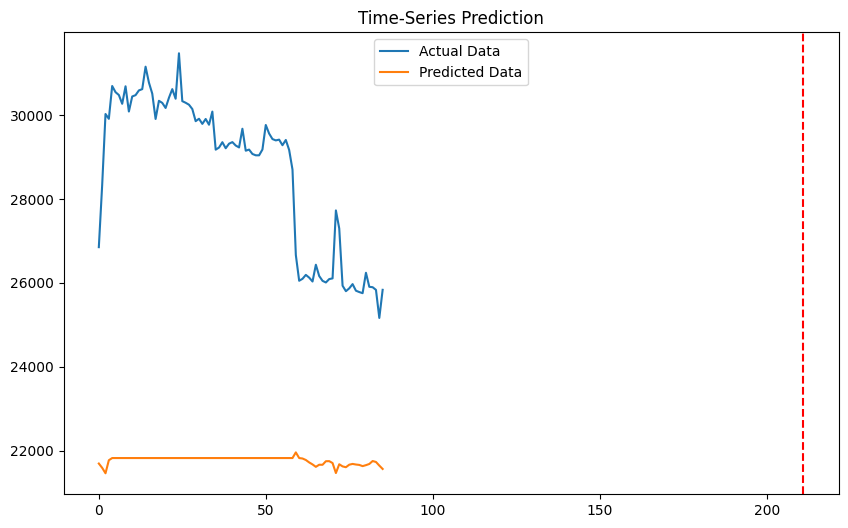

In [70]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)

# Print the current shape of input data
print("Current shape of input data:", df_X_ss.shape)

# Adjust the reshaping if the shape doesn't match the expected size
expected_shape = (df_X_ss.shape[0], 100, df_X_ss.shape[2])
if df_X_ss.shape != expected_shape:
    df_X_ss = df_X_ss.reshape(expected_shape)

# converting to tensors
df_X_ss = torch.tensor(df_X_ss, dtype=torch.float32)
df_y_mm = torch.tensor(df_y_mm, dtype=torch.float32)

# forward pass through LSTM
train_predict = lstm(df_X_ss)
data_predict = mm.inverse_transform(train_predict.squeeze().detach().numpy())
dataY_plot = mm.inverse_transform(df_y_mm.numpy())

true = dataY_plot[:, 0]
preds = data_predict[:, 0]

plt.figure(figsize=(10, 6))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--')

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()